In [3]:
import importlib, pkg_resources
importlib.reload(pkg_resources)

import tensorflow as tf
import tensorflow_quantum as tfq

import gym, cirq, sympy
import numpy as np
from functools import reduce
from collections import deque, defaultdict
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
tf.get_logger().setLevel('ERROR')

2024-02-21 16:29:24.267584: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.



In [4]:
def one_qubit_rotation(qubit, symbols):
    """
    Returns Cirq gates that apply a rotation of the bloch sphere about the X,
    Y and Z axis, specified by the values in `symbols`.
    """
    return [cirq.rx(symbols[0])(qubit),
            cirq.ry(symbols[1])(qubit),
            cirq.rz(symbols[2])(qubit)]

def entangling_layer(qubits):
    """
    Returns a layer of CZ entangling gates on `qubits` (arranged in a circular topology).
    """
    cz_ops = [cirq.CZ(q0, q1) for q0, q1 in zip(qubits, qubits[1:])]
    cz_ops += ([cirq.CZ(qubits[0], qubits[-1])] if len(qubits) != 2 else [])
    return cz_ops

In [5]:
def vqc(qubits,n_layers):   

    n_qubits = len(qubits)

    varparams = sympy.symbols(f'theta(0:{3*(n_layers+1)*n_qubits})')
    varparams = np.asarray(varparams)
    varparams = varparams.reshape(n_layers+1,n_qubits,3)

    encodparams = sympy.symbols(f'x(0:{(n_layers)})'+f'_(0:{n_qubits})')
    encodparams = np.asarray(encodparams)
    encodparams = encodparams.reshape(n_layers,n_qubits)

    circuit = cirq.Circuit()
    for j in range(n_layers):
        circuit += cirq.Circuit(one_qubit_rotation(val,varparams[j,cnt]) for cnt,val in enumerate(qubits))
        circuit += entangling_layer(qubits)

        circuit += cirq.Circuit(cirq.rx(encodparams[j,cnt])(val) for cnt,val in enumerate(qubits))

    circuit += cirq.Circuit(one_qubit_rotation(val,varparams[-1,cnt]) for cnt,val in enumerate(qubits))

    return circuit , list(varparams.flat) , list(encodparams.flat)

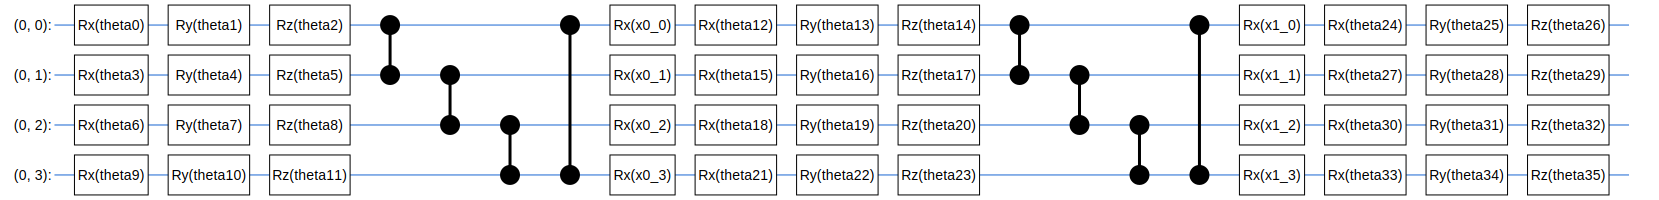

In [6]:
qubits, n_layers = cirq.GridQubit.rect(1,4),2
circuit,_,_ = vqc(qubits,n_layers)
SVGCircuit(circuit)

In [7]:
class DataReuploadVQC(tf.keras.layers.Layer):

    def __init__(self, qubits, n_layers, obs, activation='linear', name='reuploadingVQC'):
        super(DataReuploadVQC, self).__init__(name=name)

        self.n_qubits = len(qubits)
        self.n_layers = n_layers

        circuit, theta_symbols, encode_symbols = vqc(qubits,n_layers)

        init_theta = tf.random_uniform_initializer(minval=0.0, maxval=np.pi)
        self.theta = tf.Variable(initial_value=init_theta(shape=(1,len(theta_symbols))), 
                                 trainable=True,
                                 dtype='float32',
                                 name='thetas')
        
        init_lmbda= tf.ones(shape=(self.n_qubits*n_layers,))
        self.lmbda = tf.Variable(initial_value=init_lmbda,
                                 trainable=True,
                                 dtype='float32',
                                 name='lambdas')
        
        symbols = [str(symb) for symb in theta_symbols + encode_symbols]
        self.indices = tf.constant([symbols.index(i) for i in sorted(symbols)])

        self.activation = activation
        self.empty_circuit = tfq.convert_to_tensor([cirq.Circuit()])
        self.computation_layer = tfq.layers.ControlledPQC(circuit,obs)

    
    def call(self,inputs):

        batch_dim = tf.gather(tf.shape(inputs[0]), 0)
        tiled_up_circuits = tf.repeat(self.empty_circuit, repeats=batch_dim)
        tiled_up_thetas = tf.tile(self.theta, multiples=[batch_dim,1])
        tiled_up_inputs = tf.tile(inputs[0], multiples=[1, self.n_layers])
        scaled_inputs = tf.einsum("i,ji->ji", self.lmbda, tiled_up_inputs)
        squashed_inputs = tf.keras.layers.Activation(self.activation)(scaled_inputs)

        joined_vars = tf.concat([tiled_up_thetas, squashed_inputs], axis=1)
        joined_vars = tf.gather(joined_vars, self.indices, axis=1)

        return self.computation_layer([tiled_up_circuits, joined_vars])    

In [8]:
class Alternating(tf.keras.layers.Layer):
    def __init__(self,output_dim):
        super(Alternating,self).__init__()
        self.w = tf.Variable(
            initial_value=tf.constant([[(-1.)**i for i in range(output_dim)]]), dtype="float32",
            trainable=True, name="obs-weights")
        
    def call(self,inputs):
        return tf.matmul(inputs, self.w)

In [9]:
n_qubits = 4
qubits= cirq.GridQubit.rect(1,n_qubits)
n_layers = 5
n_actions = 2
temperature = 1.0

observables = [reduce((lambda x, y: x * y), [cirq.Z(q) for q in qubits])]

In [10]:
def generate_model_policy(qubits, n_layers, n_actions, temperature, observables):

    n_qubits = len(qubits)
    input_tensor = tf.keras.Input(shape=(len(qubits), ), dtype=tf.dtypes.float32, name='input')
    re_uploading_pqc = DataReuploadVQC(qubits,n_layers,observables)([input_tensor])
    process = tf.keras.Sequential([
        Alternating(n_actions),
        tf.keras.layers.Lambda(lambda x: x * temperature),
        tf.keras.layers.Softmax()
    ], name="observables-policy")
    policy = process(re_uploading_pqc)
    model = tf.keras.Model(inputs=[input_tensor],outputs=policy)

    return model

model= generate_model_policy(qubits,n_layers, n_actions, temperature, observables)

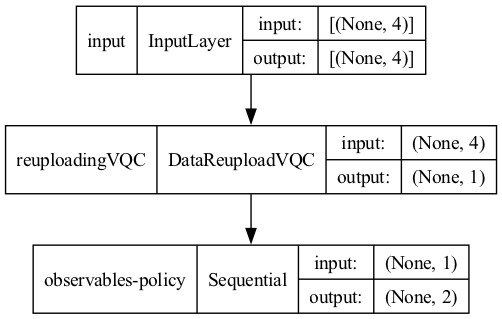

In [11]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=100)

In [20]:
def gather_episodes(state_bounds, n_actions, model, n_episodes, env_name):
    
    trajectories = [defaultdict(list) for _ in range(n_episodes)]
    envs = [gym.make(env_name) for _ in range(n_episodes)] 

    done=[False for _ in range(n_episodes)] #if False, episode not completed
    states = [e.reset() for e in envs]  #sets all current states to initial state

    while not all(done):    #while every episode has not finished
        unfinished_ids = [i for i in range(n_episodes) if not done[i]]  #stores the indexes of the unfinished episodes
        normalized_states = [s/state_bounds for i, s in enumerate(states) if not done[i]]

        for i, state in zip(unfinished_ids, normalized_states):
            trajectories[i]['statess'].append(state)   #stores current state

        states = tf.convert_to_tensor(normalized_states)
        action_probs = model([states]) #calculates the action probabilities for a given state
        print(action_probs)
        states = [None for _ in range(n_episodes)]
        for i, policy in zip(unfinished_ids, action_probs.numpy()):
            print(policy)
            action = np.random.choice(n_actions, p=policy)  #samples an action
            states[i], reward, done[i], _ = envs[i].step(action)    #takes an action
            print(done[i])
            trajectories[i]['actions'].append(action)   #stores the action
            trajectories[i]['rewards'].append(reward)   #stores the reward
    
    return trajectories

In [21]:
def compute_returns(rewards_history, gamma):
    returns = []
    discounted_sum = 0

    for r in rewards_history[::-1]:
        discounted_sum = r + gamma * discounted_sum
        returns.insert(0, discounted_sum)

    returns = np.array(returns)
    returns = (returns - np.mean(returns)) / (np.std(returns) + 1e-8)
    returns = returns.tolist()

    return returns